In [1]:
# Data
import numpy as np
import pandas as pd
import os
import csv
import xml.etree.ElementTree as ET

# Framework
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard

# Imaging
import cv2
import matplotlib.pyplot as plt
# %matplotlib inline
import seaborn as sns

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.333)
sess = tf.Session(config = tf.ConfigProto(gpu_options=gpu_options))

dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}


# Can modify the input model name here
model_name = 'acc_90_83.h5'

In [2]:
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical


def get_data(src_folder):
    imgs = []
    labels = []
    names = ['NEUTROPHIL', 'EOSINOPHIL', 'MONOCYTE', 'LYMPHOCYTE']
    for name in names:
        label = names.index(name)+1
        for img_name in tqdm(os.listdir(src_folder + name)):
            path = os.path.join(src_folder, name, img_name)
            img_file = cv2.imread(path)

            if img_file is not None:
                img_file = cv2.resize(img_file, (80, 80))
                img_arr = np.asarray(img_file)
                imgs.append(img_arr)
                labels.append(label)
    return np.asarray(imgs), np.asarray(labels)

X_train, y_train = get_data('blood-cells/dataset2-master/images/TRAIN/')
X_test, y_test = get_data('blood-cells/dataset2-master/images/TEST/')

y_trainHot = to_categorical(y_train, num_classes = 5)
y_testHot = to_categorical(y_test, num_classes = 5)


100%|██████████| 620/620 [00:00<00:00, 1421.06it/s]


In [3]:
# Normalize the dataset
X_train=np.array(X_train)
X_train=X_train/255.0

X_test=np.array(X_test)
X_test=X_test/255.0

In [4]:
# Load the trained model before plotting

from tensorflow.keras.models import load_model
model = load_model(model_name)
print("\nPrinting model summary...")
model.summary()


Printing model summary...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 78, 78, 32)        896       
_________________________________________________________________
activation_3 (Activation)    (None, 78, 78, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 37, 32)        9248      
_________________________________________________________________
activation_4 (Activation)    (None, 37, 37, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)  

In [5]:
validation_loss, validation_accuracy = model.evaluate(X_test, y_testHot)
print("\n\nTesting set validation loss", validation_loss)
print("Testing set Validation accuracy:",validation_accuracy)

2487/2487 [==============================] - 3s 1ms/step


Testing set validation loss 0.38179084229023524
Testing set Validation accuracy: 0.8307197426618416


In [6]:
validation_loss, validation_accuracy = model.evaluate(X_train, y_trainHot)
print("\nTraining set validation loss", validation_loss)
print("Training set validation accuracy:",validation_accuracy)

9957/9957 [==============================] - 12s 1ms/step

Training set validation loss 0.204449489347884
Training set validation accuracy: 0.9039871447223059


In [7]:
model.get_config()

{'name': 'sequential_1',
 'layers': [{'class_name': 'Conv2D',
   'config': {'name': 'conv2d_3',
    'trainable': True,
    'batch_input_shape': (None, 80, 80, 3),
    'dtype': 'float32',
    'filters': 32,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'activation': 'linear',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None, 'dtype': 'float32'}},
    'bias_initializer': {'class_name': 'Zeros',
     'config': {'dtype': 'float32'}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Activation',
   'config': {'name': 'activation_3',
    'trainable': True,
    'dtype': 'float32',
    'activation': 'relu'}},
  {'class_name': 'MaxPooling2D',
   'config': {'name': 'max_pooling2d_3',
    'trainable': True,
    'dtype

In [8]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
test_result = model.predict(X_test)
x1 = np.argmax(test_result, axis=1)
x2 = np.argmax(y_testHot, axis = 1)
cm = confusion_matrix(x2, x1)
cm = cm/np.sum(cm)
print("\nPrinting the confusion matrix...\n", cm)


Printing the confusion matrix...
 [[0.23683152 0.01005227 0.00402091 0.        ]
 [0.09368717 0.15681544 0.         0.        ]
 [0.06111781 0.         0.18817853 0.        ]
 [0.00040209 0.         0.         0.24889425]]


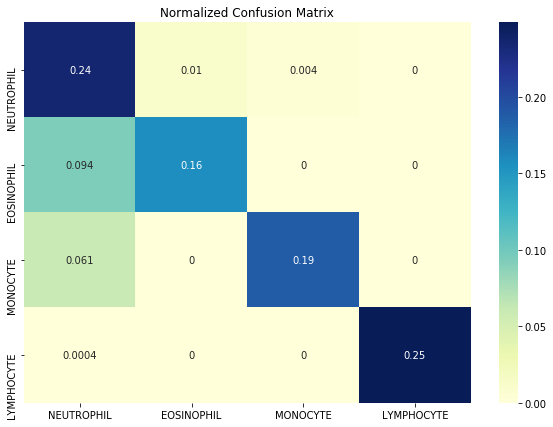

In [9]:
names = ['NEUTROPHIL', 'EOSINOPHIL', 'MONOCYTE', 'LYMPHOCYTE']
df_cm = pd.DataFrame(cm, index = names,
                  columns = names)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap="YlGnBu")
plt.title("Normalized Confusion Matrix")
plt.savefig("Normalized_CM.png")
plt.show()